In [55]:
using Pkg

Pkg.activate(".")

using MiCRM_stability
using Distributions,LinearAlgebra,StatsBase, Distances
using CairoMakie
using DelimitedFiles
using GLM

  Activating project at `~/Projects/MiCRM_stability`


In [56]:
function get_param_mean(p::MiCRM_stability.Parameters)
    fe = fieldnames(MiCRM_stability.exponential_params)
    fs = fieldnames(MiCRM_stability.structural_params)

    ue = mean.(getfield.(Ref(p.e), fe))
    us = mean.(getfield.(Ref(p.s), fs))

    vcat(ue...,us...) 
end

function get_real(x::T) where T <: AbstractFloat
    x
end

get_real(x::Complex) = x.re

Revise.revise()

In [75]:
N,M = 30,30
Ncom = 100000
Nrep = 1

J = 0
k = [0]

λ_mat = zeros(Complex,Ncom, Nrep)
p_mat = Array{Float64,3}(undef, Ncom, Nrep,27)
s_mat = Array{Tuple,2}(undef, Ncom, Nrep)
p = 0

Threads.@threads for i = 1:Ncom
    C = 0.3
    # N = 50 #rand(1:100)
    # M = 50 #rand(1:100)
    
    k[1] += 1
    if k[1] % 100 == 0
        print("\r", k)
    end
    J = zeros(N+M,N+M)
    
    c = MiCRM_stability.niche_model(N,M,C)

    #set end and start points
    c.L[end,:] .= 0
    c.U[:,end] .= 0
    
    s_vec = [mean(pairwise(Jaccard(), eachcol(c.U), eachcol(c.U))), 
             mean(pairwise(Jaccard(), eachcol(c.U), eachcol(c.U * c.L))),
            N,M,mean(c.U),N/M, 0]
    
    for j = 1:Nrep
        sp = MiCRM_stability.get_structural_params(c.U .> 0, (c.U * c.L .> 0), c.N, c.M)
        ep = MiCRM_stability.get_exponential_parameters(c.N, c.M)

        p = MiCRM_stability.Parameters(N,M,sp,ep)
        
        s_vec[end] = mean(p.e.ωy ./ (p.e.λy .+ p.e.ωy))
        
        MiCRM_stability.jacobian!(p, J)
        λ_mat[i,j] = get_real(eigvals(J)[end])
        p_mat[i,j,:] .= vcat(get_param_mean(p), s_vec)
    end
end

println("\n", sum([l.re < 0 for l = λ_mat[:]]) )

[99900]
36765


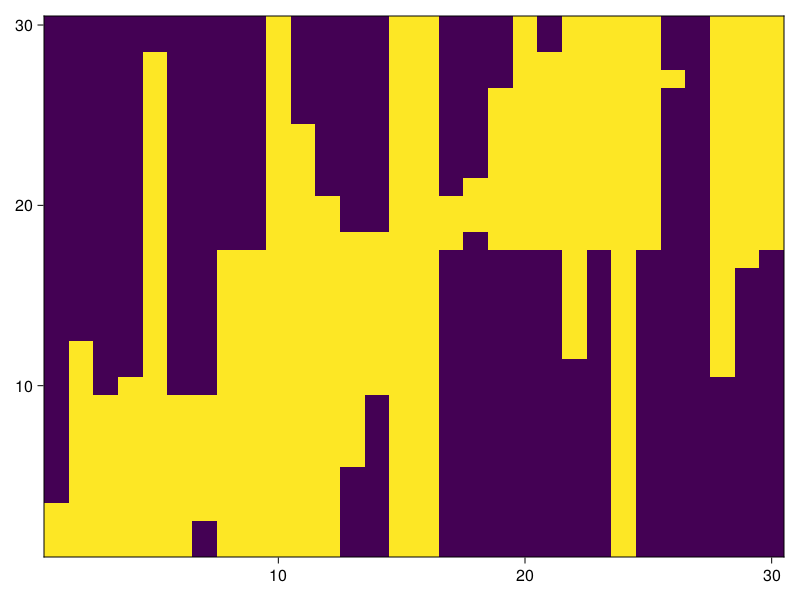

In [76]:
c = MiCRM_stability.niche_model(N,M,0.3)
heatmap(c.U)

In [86]:
mean(pairwise(Jaccard(), eachcol(c.U), eachcol(c.U)))

0.4627482746831725

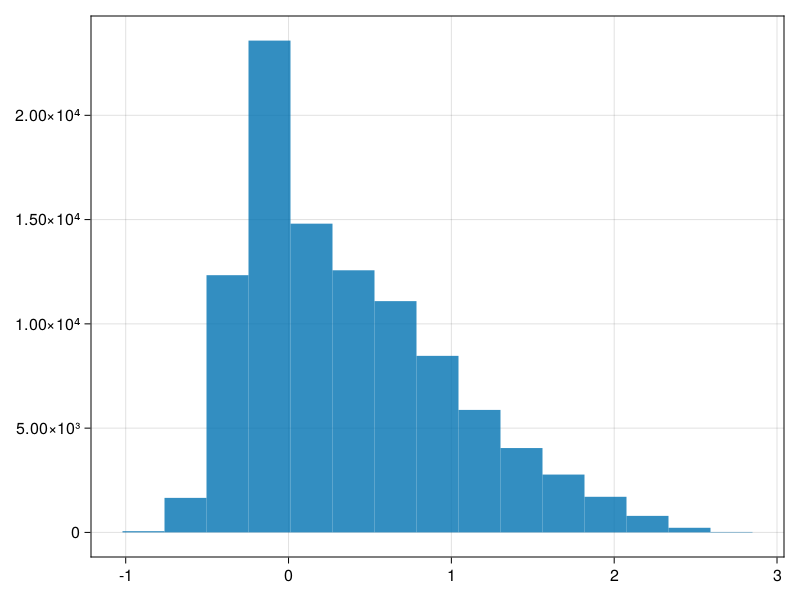

In [87]:
hist(Real.(λ_mat)[:])

In [88]:
fe = fieldnames(MiCRM_stability.exponential_params)
fs = fieldnames(MiCRM_stability.structural_params)

x = [cor([l.re < 0 for l = λ_mat[:]],r[:]) for r = eachslice(p_mat, dims = 3)]

hcat(vcat([fe...,fs...,"U","L","N","M","C","N/M","Λ"]...), x)

27×2 Matrix{Any}:
 :gx     -0.543315
 :gs      0.0596172
 :gw      0.00548802
 :mx      0.191878
 :fy     -0.00116994
 :hy     -0.0053717
 :λy     -0.0110174
 :ωy      0.0057954
 :iy     -0.0604918
 :oy      0.0654537
 :α      -0.000996393
 :β       0.00132917
 :ρ       0.0311185
 ⋮      
 :σ̃      -0.0864604
 :γ       0.00241124
 :η      -0.000891769
 :χ      -0.000343875
 :ϕ      -0.000931875
 "U"    NaN
 "L"    NaN
 "N"    NaN
 "M"    NaN
 "C"      0.00592155
 "N/M"  NaN
 "Λ"     -0.000611831

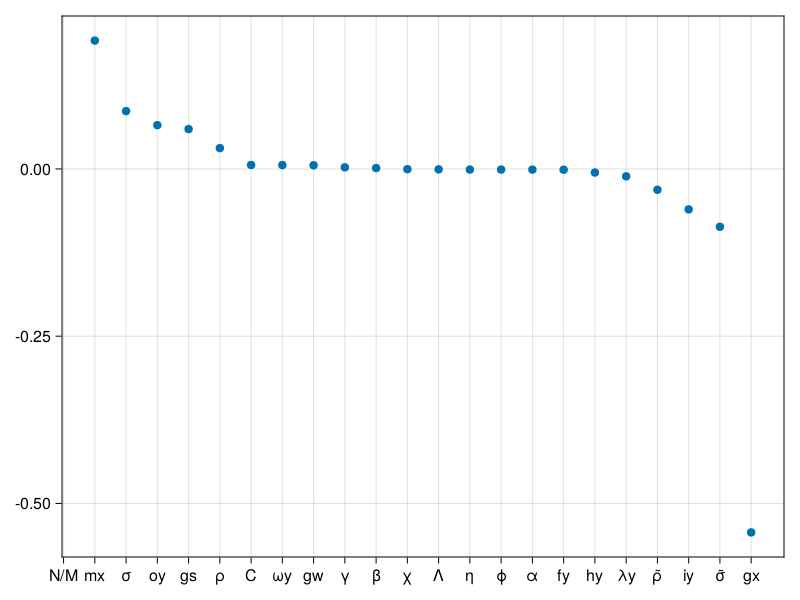

In [89]:
s_ind = sortperm(x,rev=true)

f = Figure()
ax = Axis(f[1,1], xticks = (1:27, string.(vcat([fe...,fs...,"U","L","N","M","C","N/M","Λ"]...))[s_ind]))

scatter!(ax, x[s_ind])

f

# Empirical Webs

In [90]:
#read empirical matricies
C = readdlm("./data/C_mat.csv",',') .> 0
K = readdlm("./data/D_mat.csv",',') .> 0;

N = 30
indx = sample(1:size(C)[1], N, replace = false)

C_sub = C[indx,:]

#shuffle whilst preserving marginal probabiliyties
function get_p_mat(A)
    row_μ = mean(A, dims = 2)[:]
    col_μ = mean(A, dims = 1)[:]
    
    return [(c + r)/2 for r = row_μ, c = col_μ]
end

function get_exponential_parameters(N,M)
    σ = 0.1
    gx = ones(N)
    gs = 2ones(N)
    gw = -ones(N)
    
    mx = 2ones(N)
    
    fy = ones(N,M)
    hy = ones(N,M)
    
    λy = ones(N,M)
    ωy = ones(N,M)
    
    iy = ones(M)
    oy = 2ones(M)

    return MiCRM_stability.exponential_params(gx,gs,gw,mx,fy,hy,λy,ωy,iy,oy)
end

get_exponential_parameters (generic function with 1 method)

In [91]:
Nrep = 10
Nstab = 100

N = 30

stability = zeros(Nrep,Nstab, 2)

k = [0]

for r = 1:Nrep
    k[1] += 1
    print(k[1], "\r")

    indx = sample(1:size(C)[1], N, replace = false)

    C_sub = C[indx,:]
    K_sub = K[indx,:]
    
    M = size(C_sub)[2]
    s = MiCRM_stability.get_structural_params(C_sub, K_sub, N, M)

    Threads.@threads for st = 1:Nstab
        # print(r, " 1 ", st,"\r")
        e = MiCRM_stability.get_exponential_parameters(N, M)
        p = MiCRM_stability.Parameters(N, M, s, e)
        J = zeros(N+M, N+M)
        MiCRM_stability.jacobian!(p, J)
        stability[r,st,1] = get_real(eigvals(J)[end]) < 0
    end

    #randomised
    rC = get_p_mat(C_sub) .< rand(N,M)
    rK = get_p_mat(K_sub) .< rand(N,M)
    
    s = MiCRM_stability.get_structural_params(rC, rK,N,M)

    Threads.@threads for st = 1:Nstab
        # print(r, " 2 ", st,"\r")
        e = MiCRM_stability.get_exponential_parameters(N,M)
        p = MiCRM_stability.Parameters(N,M,s,e)  
        J = zeros(N+M,N+M)
        MiCRM_stability.jacobian!(p, J)
        stability[r,st,2] = get_real(eigvals(J)[end]) < 0
    end
end

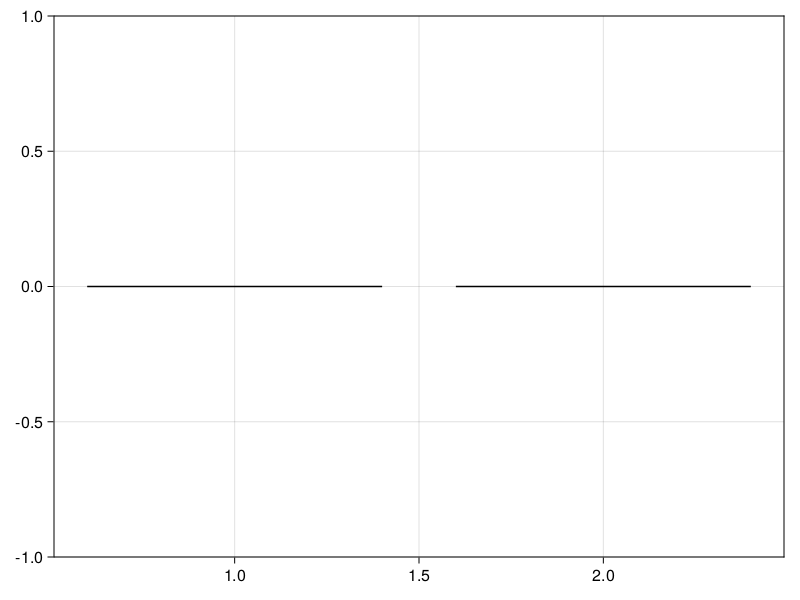

In [100]:
p_stab = mean(stability, dims = (2))[:,1,:]

f,ax = boxplot(ones(Nrep), p_stab[:,1])
boxplot!(ax, 2ones(Nrep), p_stab[:,2])

f

In [15]:
sum(stability)

7.0

In [7]:
λ = Vector{Eigen}(undef, 1000)

s = MiCRM_stability.get_structural_params(C[indx,to_keep], K[indx,to_keep], N, M)

for i = 1:1000 
    print(i, "\r")
    e = MiCRM_stability.get_exponential_parameters(N,M)
    p = MiCRM_stability.Parameters(N,M,s,e)

    J = zeros(N + M, N + M)
    MiCRM_stability.jacobian!(p, J)

    λ[i] = eigen(J)
end

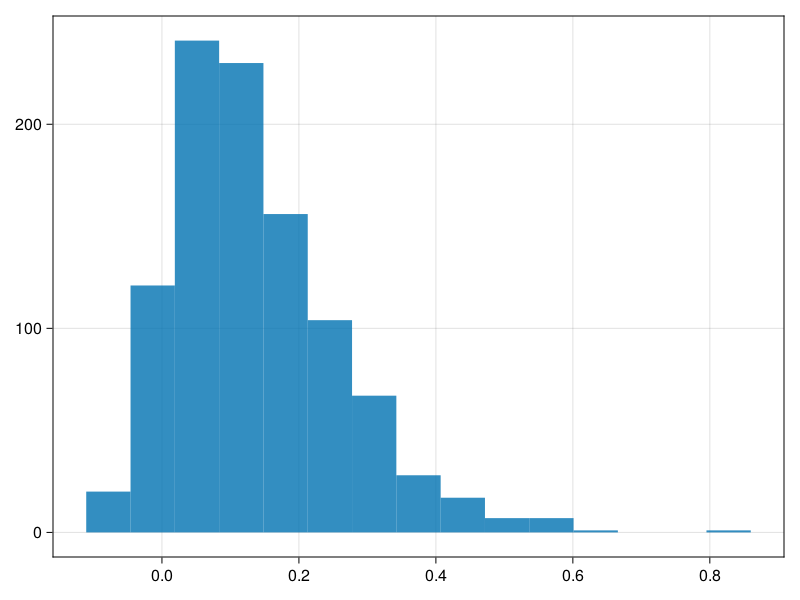

In [8]:
f(x) = isa(x, Complex) ? x.re : x
hist([f(x.values[end]) for x = λ])

# Dimensionality

In [25]:
#struct with an ordering of M resources
mutable struct ordering{T}
    N::Int64
    M::Int64
    D::Int64
    order::T
    A::Matrix{Int64}
    e::Int64
end

#swap i to j on dimension D
function invert!(o::ordering, i::Int64,j::Int64,D::Int64)
    o.order[:,D] .= reverse(o.order[:,D], i, j)
end

function swap!(o::ordering, i::Int64,j::Int64,D::Int64)
    a = o.order[i,D]
    o.order[i,D] = o.order[j,D]
    o.order[j,D] = a
end



function calculate_error!(o::ordering)
    o.e = 0 #clear current error
    sums = zeros(o.M) #to store diet limits
    
    #loop over each species
    for i = 1:o.N
        #clear lims
        sums .= 0

        #loop over dimensions
        for (j,o_D) = enumerate(eachcol(o.order))
            
            #get diet of i in dimension j
            d_i = o_D[A[i,:] .== 1]
            if !isempty(d_i)
                
                #get niche limits
                lims = extrema(d_i)
                #add 1 to resources within limits
                sums .+= lims[1] .<= o_D .<= lims[2]
            end
            
        end
        o.e += (sum(sums .== o.D)) - (sum(A[i,:]))
    end
end

calculate_error! (generic function with 1 method)

In [26]:
N = 10
M = 20
D = 3

#random binary network
A = zeros(Int64, N,M)
A[rand(1:100, 25)] .= 1

#random order
order = hcat([sample(1:M, M, replace = false) for i = 1:D]...);
o = ordering(N,M,D,order,A,N*M)
o.order

20×3 Matrix{Int64}:
 16  13   4
  9   6   2
  3  17   7
  4  12  18
 12   5  17
 15  14  11
 13  18   3
 18   7  12
  5  10   9
 17   8   6
 20   9   5
  2   2  19
  1  19  10
 14  15  14
  8  20  15
  7   3  20
  6  11  13
 10  16   8
 19   1   1
 11   4  16

In [232]:
#GA
struct Population{T}
    N::Int64
    individuals::Vector{T}
    scores::Vector{Int64}
    t::Int64
end

function calculate_fitness!(P::Population)
    for (i,ind) = enumerate(P.individuals)
        calculate_error!(ind)
        P.scores[i] = ind.e
    end
end

function propagate!(P::Population)
    #normalise scores to get probability
    sd = std(P.scores) 
    sd = sd == 0 ? 1 : sd
    z_score = (P.scores .- mean(P.scores)) ./ sd
    p = 1 ./ (1 .+ exp.(10z_score))
    p = p ./ sum(p)
    new = sample(1:P.N, weights(p), P.N)
    P.individuals .= P.individuals[new]
end

function mutate!(P::Population)
    for i = P.individuals
        for D = 1:i.D
            swap!(i, rand(1:i.M), rand(1:i.M), D)
            if rand() < 0.0
                s = rand(1:i.M)
                e = rand(s:i.M)
                invert!(i,s,e,D)
            end
        end
    end
end



mutate! (generic function with 1 method)

In [240]:
N_pop = 100
N = 20
M = 20
D = 10

A = zeros(Int64, N,M)
A[rand(N,M) .> 0.5] .= 1

order = [hcat([sample(1:M, M, replace = false) for i = 1:D]...) for j = 1:N_pop]
individuals = [ordering(N,M,D,order[i],A,10) for i = 1:N_pop]

P = Population(N_pop, individuals, ones(Int64, N_pop), 0)
calculate_fitness!(P)

res = Vector{Population}(undef, 101)
res[1] = deepcopy(P)

for i = 1:100
    propagate!(P)
    mutate!(P)
    calculate_fitness!(P)
    res[i+1] = deepcopy(P)

    print(i, "\r")
end

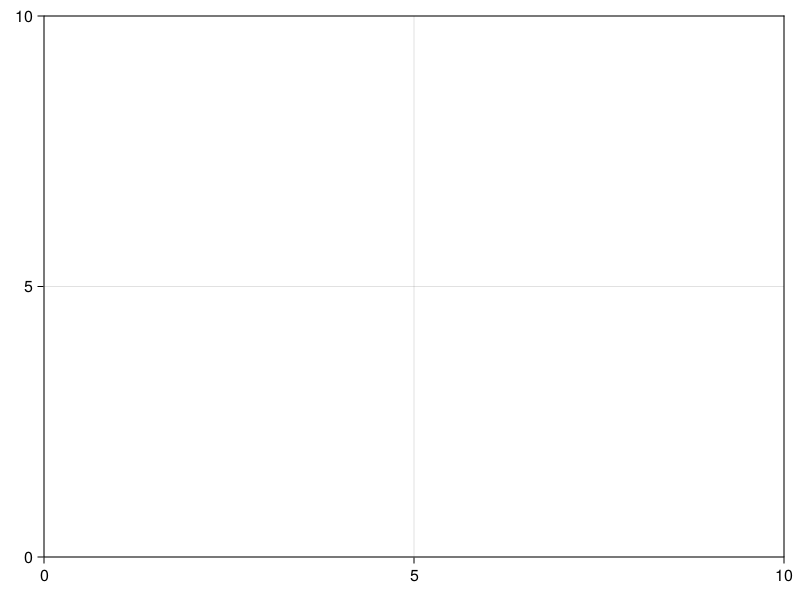

In [247]:
x = res[20]
z = (x.scores .- mean(x.scores)) ./ std(x.scores)
p = 1 ./ (1 .+ exp.(10z))

scatter(x.scores,p)

In [122]:
calculate_fitness!(P)
std(P.scores)

0.0

In [542]:
C_sub = C[1:10,1:10]

#calculate error
#D1
e = 0

order = [sample((1:10), 10, replace = false) for i = 1:2]

for o = order
    for i = o
        f_ind = findfirst(C_sub[i,o])
        l_ind = findlast(C_sub[i,o])
    
        if f_ind != l_ind
        s = l_ind - f_ind - sum(C_sub[i,f_ind:l_ind]) + 1
            e += s
        end
    end
end
e

56

In [413]:
order

2-element Vector{Vector{Int64}}:
 [7, 8, 9, 2, 1, 4, 10, 6, 5, 3]
 [7, 5, 10, 1, 3, 4, 8, 6, 9, 2]

In [3]:
#test 
#construct uptake, leakage and effective leakage
U = fu(nC,nR,f_guassian)
U[:,end] .= 0.0

# U = rand(N,M)

L = fl(nC,nR,f_guassian)
L = 0.3 * L ./ (norm.(eachrow(L), 1))
L[isnan.(L)] .= 0.0

K = U * L;

f = Figure(resolution = (1000,300))
ax = [Axis(f[1,i]) for i = 1:3]

[heatmap!(ax[i], m) for (i,m) = enumerate([U,L,K])]

f

LoadError: UndefVarError: `fu` not defined

In [8]:
N,M = size(rand(2,2))

(2, 2)

In [279]:
function get_structural_params(U,K)
    N,M = size(U)
    #structural
    α = ones(N)
    β = ones(M)
    
    #branching
    ρ = zeros(N)
    ρ[sum(K,dims=1)[:] .== 0] .= 1.0
    ρ̃ = 1 .- ρ
    
    σ = zeros(N)
    σ[sum(U,dims=1)[:] .== 0] .= 1.0
    σ̃ = 1 .- σ
    
    γ = U ./ (norm.(eachcol(U), 1)')
    η = K ./ (norm.(eachcol(K), 1)')
    χ = U ./ (norm.(eachrow(U), 1))
    ϕ = K ./ (norm.(eachrow(K), 1))
    
    γ[isnan.(γ)] .= 0.0 
    η[isnan.(η)] .= 0.0 
    χ[isnan.(χ)] .= 0.0 
    ϕ[isnan.(ϕ)] .= 0.0 

    return MiCRM_stability.structural_params(α,β,ρ,ρ̃,σ,σ̃,γ,η,χ,ϕ);
end

get_structural_params (generic function with 1 method)

In [262]:
function get_exponential_parameters(N,M)
    gx = (0.5) .+ (rand(N) / 2)
    gs = (0.5) .+ (rand(N))
    gw = -(0.5) .+ (rand(N))
    
    mx = ones(N)
    
    fy = ones(N,M) .+ rand(Normal(0,0.1), (N,M))
    hy = ones(N,M)
    
    λy = zeros(N,M)
    ωy = zeros(N,M)
    θy = zeros(N,M,M)
    
    iy = (0.5) .+ (rand(M) / 2)
    oy = (0.5) .+ (rand(M) / 2)

    return MiCRM_stability.exponential_params(gx,gs,gw,mx,fy,hy,λy,ωy,θy,iy,oy)
end

In [263]:
p = MiCRM_stability.Parameters(N,M,s,e);

J = zeros(N + M, N+M)
MiCRM_stability.jacobian!(p,J)

CC = J[1:N , 1:N] 
CR = J[1:N , N+1:end] 
RC = J[N+1:end, 1:N]
RR = J[N+1:end, N+1:end]

mean_no_zero(x) = mean(x[x .!= 0.0])

mean_no_zero.([CC,CR,RC,RR])

4-element Vector{Float64}:
 -0.2544736575424741
  0.010540030178867104
  5.035397068794012e-6
 -6.157722753269433e-5

In [264]:
CR

100×100 Matrix{Float64}:
 0.032776    0.030143    0.031642    …  -0.000137642  -0.000130183
 0.0379548   0.0375843   0.0366442      -0.000136422  -0.000129399
 0.0340495   0.0384692   0.0394199       0.000131644   0.000116517
 0.0262613   0.0239471   0.0266606       0.000207333   0.000189435
 0.0196623   0.0208389   0.0269363      -0.000182148  -0.000175596
 0.0148216   0.0179108   0.015716    …  -0.000105979  -0.000102115
 0.0191568   0.0178457   0.019923        0.000201306   0.000183354
 0.0302232   0.0366589   0.0382109       1.8671e-5     8.8545e-6
 0.0268096   0.0269442   0.0273539      -0.000236863  -0.000232532
 0.0203775   0.0207081   0.0203777      -0.000435159  -0.00041834
 0.0147859   0.0115642   0.0160489   …   0.000289767   0.000261106
 0.0229267   0.0228852   0.0198779       0.000156477   0.000129874
 0.0125274   0.0113621   0.0134744       0.000103099   8.74567e-5
 ⋮                                   ⋱                
 9.00926e-6  8.36211e-6  9.49688e-6      0.0198889   

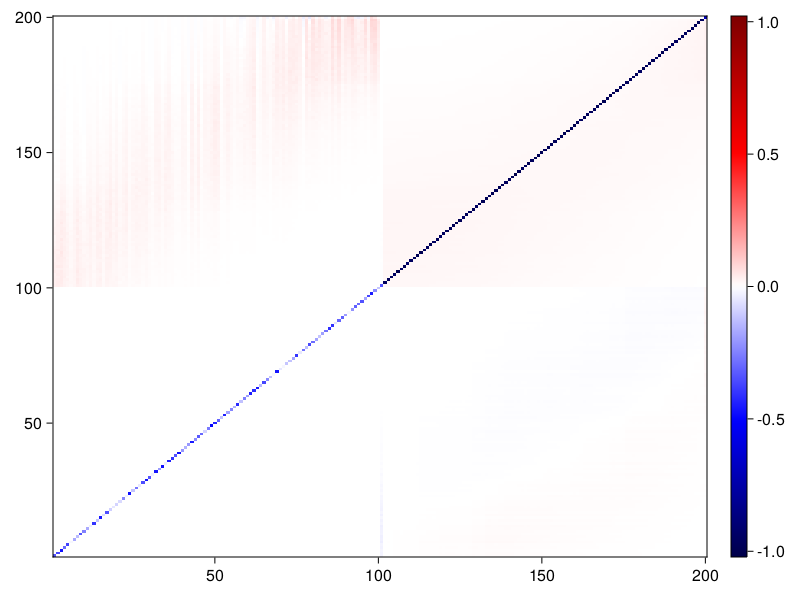

In [265]:
crange(x) = (-maximum(abs.(x)), maximum(abs.(x)))
f,ax,p = heatmap(J, colormap = :seismic, colorrange = crange(J[:]))
Colorbar(f[1,2], colorrange = crange(J[:]), colormap = :seismic)
f

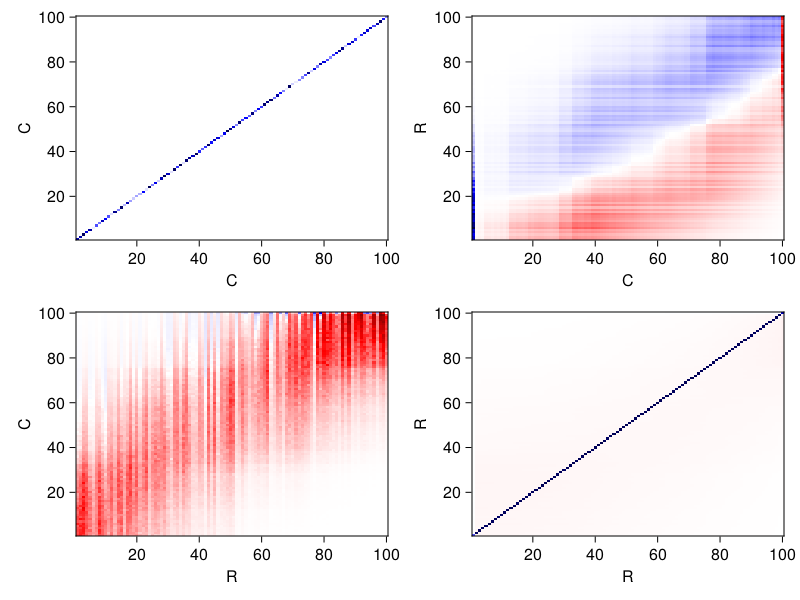

In [266]:
f = Figure()

label = ["C","R"]

ax = [Axis(f[i,j], xlabel = label[i], ylabel = label[j]) for i = 1:2, j = 1:2]

[heatmap!(ax[i], m, colormap = :seismic, colorrange = crange(m[:])) for (i,m) = enumerate([CC,CR,RC,RR])]

f

-0.010418953791251467 + 0.10467619402483183im

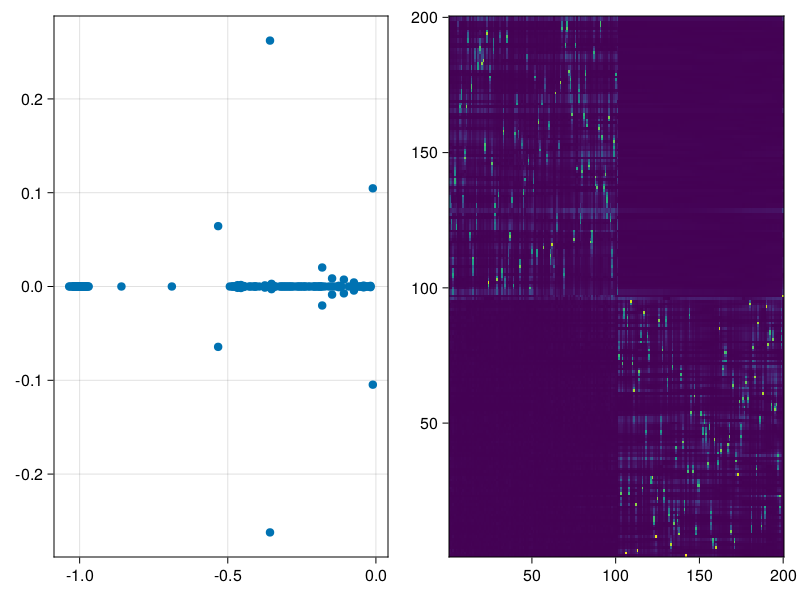

In [276]:
λ = eigen(J)

print(λ.values[end])

r = [x.re for x = λ.values]
i = [x.im for x = λ.values]

f,ax = scatter(r,i)
heatmap!(Axis(f[1,2]), norm.(λ.vectors[:,:]))
f

In [174]:
J[150,150]

-0.968747033309227

In [155]:
a = 50
b = 50

p.s.ρ[a] * p.e.iy[a] - p.s.σ[a] * p.e.oy[a]

0.0

In [167]:
sigma = [p.s.σ̃[a] * p.s.γ[i,a] * (p.e.fy[i,a] * (p.s.χ[i,a] * (p.e.gs[i] - 1) +1) + 
                    p.e.gw[i] * p.s.ϕ[i,a] * p.e.hy[i,a]) for i = 1:N]

sum(sigma)

1.0038254017974517

In [169]:
rho = [p.s.ρ̃[a] * p.s.η[i,a] * (p.e.gs[i] * p.s.χ[i,a] * p.e.fy[i,a] + p.e.gw[i] * p.s.ϕ[i,a] * p.e.hy[i,a] + 
        p.e.λy[i,a] + p.e.θy[i,a,a]) for i = 1:N]

sum(rho)

2.0186015914172235

In [170]:
K[a,b]

0.24206729057248955